<div align="center">
<a href="https://vbti.nl"><img src="./images/vbti_logo.png" width="400"></a>
</div>

In [3]:
# load some default libraries
%run default_setup.py
%matplotlib inline

%load_ext autoreload
%autoreload 2

Loaded numpy as np, pandas as pd, matplotlib as plt, seaborn as sns and tensorflow as tf.


# Deep Q-Network <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">[paper]</a>

In the previous chapter the Q-learning algorithm in tabular form was extended to problems with continuous states via (state/action) value function approximation. By using a linear function approximation, it was shown in [1] that the algorithm converges.

In some situations, using linear function approximation of the value function is not sufficient. For instance, when using RL to play Atari games, the state consists of screen frames. An Atari screen frame is an image of size 210x160 with RGB pixels. The total number of possible single frames is $(210 * 160)^{255}$. Obviously, this number of states cannot be stored as a value function in table form. 

Recently, convolutional neural networks have been shown to be very effective in processing images. A CNN is, just like any other neural network, a non-linear function approximator. By combining CNN's with RL an algorithm is derived called **Deep Q-Network** that can be used to solve playing Atari games.

<img src="images/dqn_alg.png" width=600 />
<center> DQN algorithm from original <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">[paper]</a></center>

As you can see wee need to implement couple of things.
1. Neural Network
2. Epsilon Greedy agent that will use the Network for exploitation phase
3. Experience Replay for training the network
4. Input Preprocessing (which is not in the algorithm but it is very important)

First we will define how to preprocess frames from the gym environment. Then we will define the neural network architecture and its training procedure. Then we implement Experience Replay and then we move to the functionality of the agent. Full implementation is located in ```dqn``` python package. Here we present only the snippets of code alongside with the explanation.

## Frame Preprocessing
The DQN will use the Atari screen frame as state. However, from a single frame the velocity of objects cannot be estimated. In [chapter 3](03_FiniteMarkovDecisionProcess.ipynb) is was mentioned that in the RL framework the environment is modeled as a Markov Decision Process. One requirement for a proper working of the RL algorithm is that the current state contains all the information that is needed to predict the next state this is usually referred to as Markovian Property. While several mechanisms can be applied to add velocity information to the Atari state, in this notebook we will use a stack of (4) frames as state. The CNN should now be able to derive the velocity itself.

To make the learning more efficient, we remove 'unused' information from the stacked frames. That is, probably the color information is not essential to the learning, as is using the whole frame. Therefore, every frame is converted to gray scale and cropped to 84x84 size.

In [8]:
from env_wrappers import AtariPreprocessing, AtariFrameStack
import matplotlib.pyplot as plt

import gym


env = gym.make('PongNoFrameskip-v0')
print('Original state shape', env.observation_space)
env_preprocessed = AtariPreprocessing(env, frame_skip=4)
print('Preprocessed state shape', env_preprocessed.observation_space)
env_stacked = AtariFrameStack(env, frame_skip=4)
print('Stacked state shape', env_stacked.observation_space)

Original state shape Box(210, 160, 3)
Preprocessed state shape Box(84, 84)
Stacked state shape Box(84, 84, 4)


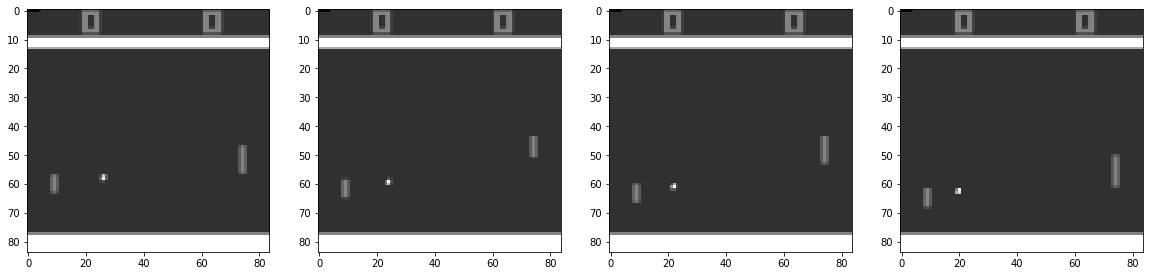

In [11]:
def plot_stack(frame_stack):
    num_frames = frame_stack.shape[-1]
    fig, ax = plt.subplots(1, num_frames, figsize=(20, 20), )
    for i in range(num_frames):
        ax.flat[i].imshow(frame_stack[..., i], cmap='gray')
        ax.flat[i].grid(False)
    plt.show()
    

state = env_stacked.reset()
for i in range(20):
    state, _, _, _ = env_stacked.step(env.action_space.sample())
plot_stack(state)

The plot above is the visualization of what the agent perceives as state. The leftmost is the the oldest frame in the stack and it is going away as soon as new observation is obtained (therefore we can derive that the ball is moving to the left). Since we had concatenated the frames on the channel dimension, the frame-stack can be used an input to the Convolution Neural Network. 

## Network architecture
Convolutional Neural Networks are very suitable for processing high dimensional image data. For this task a simple feed forward architecture with three convolutional layers will do the job. 

<div align="center">
<img src="./images/DQN_Atari.png" width="800">
</div>

Also, instead of estimating $\hat{Q}(s,a|\textbf{w})$ the CNN outputs a q-value for every action, that is $\hat{Q}_{action_i}(s|\textbf{w})$. Hence, the CNN is a multi-output CNN. While fundamentally nothing changes, it is a more efficient way of implementing the algorithm.


```python

def create_model(self, model_name):
    input_state = tf.keras.Input(shape=self.state_shape,
                                 batch_size=None,
                                 name='state_input',
                                 dtype=tf.uint8)

    x = tf.divide(tf.cast(input_state, dtype=tf.float32), tf.constant(255., dtype=tf.float32))

    x = Conv2D(16, kernel_size=(8, 8), strides=(4, 4),
               padding='valid', activation='relu', name='conv1')(x)
    x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2),
               padding='valid', activation='relu', name='conv2')(x)
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
               padding='valid', activation='relu', name='conv3')(x)

    x = Flatten()(x)

    x = Dense(512, activation='tanh', name='hidden_dense_value')(x)

    q_values = Dense(self.n_actions, activation='linear', name='value_output')(x)

    q_network = Model(inputs=[input_state], outputs=[q_values], name=model_name)
    return q_network

```

We will assign this model to our DeepQNetwork class as a property.
```python
class DeepQNetwork:
    def __init__(self, state_shape, n_actions, learning_rate=1e-4, gamma=0.99):
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.online_network = self.create_model('dqn')

```
We can now define a couple of methods that would allow us to train and query the network.
    
Exploit the best option $argmax_a Q(s, a; \theta)$
```python
@tf.function
def get_best_action(self, state):
    return tf.argmax(self.online_network(state), axis=1)
```
Get maximum q-values from given state $max_a Q(s, a; \theta)$
```python
@tf.function
def get_best_action_value(self, state):
    return tf.reduce_max(self.online_network(state), axis=1)
```

For the network to be properly defined, we need to specify how the network is going to be trained. For training the network we are going to defined one training operation, i.e. gradient descent for one batch of transition data sampled from replay buffer. Steps in this method:
- Calculate the target
$$y=r+\gamma \max_{a'}Q(s',a';\theta)$$
- Calculate the loss
$$L(\theta) = \mathbb{E}[(y - Q(s,a;\theta)^2)]$$
- Perform gradient descent
$$\nabla_{\theta}L(\theta) = \mathbb{E}\left[(r + y - Q(s, a; \theta))\nabla_{\theta}Q(s, a;\theta)\right]$$

```python
    @tf.function
    def train_op(self, replay_state, replay_action, replay_rewards, replay_next_state, terminal):
        replay_continues = 1.0 - terminal
        # max_a` Q(s`, a`)
        q_best_next = self.get_best_action_value(replay_next_state)
        # calculate target, if episode is over do not add next q-values to the target
#         y_i = r + gamma * max_a` Q(s`, a`)
        y_val = replay_rewards + replay_continues * self.gamma * q_best_next
        with tf.GradientTape() as tape:
            # calculate current q-values
            q_values = self.online_network(replay_state)
            # get the q-values of the executed actions
            q_values_masked = tf.reduce_sum(q_values * tf.one_hot(replay_action, self.n_actions), axis=1, keepdims=True)
            # calculate loss
            loss = self.loss_layer(q_values_masked, y_val)
        # compute gradients
        gradients = tape.gradient(loss, self.online_network.trainable_variables)
        # apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.online_network.trainable_variables))
        return loss

```

## Replay Memory

We might be tempted to perform gradient update every time we have a new batch of observations ready. However, the several consequent observations are dependent on each other. This correlation breaks the qualification for stochastic gradient descent, since one of the assumption is that the batch data is i.i.d. sample from a certain distribution. In order to break this correlation we are going to use Experience Replay. First we collect the experiences in a buffer, then we sample a batch from it and perform a gradient update. We also include 3 of the most recent observations in the sample to make sure that the training is performed on each of the observations at least once. It is very convenient and fast to use a ```collections.deque``` for this. This standard Python data-structure can maintain fixed length by removing the oldest elements when the capacity is reached.

```python
from collections import deque

class ReplayBuffer:
    def __init__(self, replay_capacity=50000, include_last_samples=3):
        self.include_last = include_last_samples
        self._buffer = deque(maxlen=replay_capacity)

    def store(self, transition):
        self._buffer.appendleft(transition)

    def sample_batch(self, batch_size):
        batch = random.sample(self._buffer, batch_size)
        for i in range(self.include_last):
            batch[i] = self._buffer[i]
        return self._batch_to_arrays(batch)
```

## Agent and Exploration
First we define an interface for an agent. ```compute_action``` would return the next action given state. ```update``` is used for agent training. And if we were recording any statistic during the episode we would return it in ```finalize_episode```.

```python
class Agent:
    """
    Interface for the agent class
    """

    def compute_action(self, state):
        ...

    def update(self, *args, **kwargs):
        ...

    def finalize_episode(self, *args, **kwargs):
        ...
```
We can easily extend this class to implement RandomAgent.

```python
class RandomAgent(Agent):

def __init__(self, n_actions):
    self.n_actions = n_actions

def compute_action(self, state):
    return random.randrange(self.n_actions)
```

In order to bind everything together we are going to assign a network and replay buffer to the ```EpsilonGreedyAgent``` class. Lets have a look at its main methods.

```python
class EpsilonGreedyAgent:
    def __init__(self, n_actions, network):
        super().__init__(n_actions)
        self.network = network
        self.replay_buffer = ReplayBuffer(replay_capacity)
```

Now we defined function for computing next state. For this we use our current epsilon value, where 1.0 means only exploration and 0.0 is only exploitation.
```python
    def compute_action(self, state):

        if np.random.rand() < self.epsilon:
            return super().compute_action(state)
        else:
            action = self.network.get_best_action(state)
            return action
```
We are going to anneal the epsilon value from 1.0 to 0.02 with this formula.
$$\epsilon = \epsilon_{min} + (\epsilon_{max} - \epsilon_{min}) * exp(-\epsilon_{decay} * t)$$, where $t$ is the current timestep. In most of the papers the training lasts until 200 million frames. Pong, however is a bit easier game, so we don't need to explore for too long. We are going to train for approx. 5 million frames, therefore $\epsilon_{decay}$ should be $10^{-6}$ to make sure that the agent explores actively for at least half of that time. We can see the exploration value on the plot bellow.

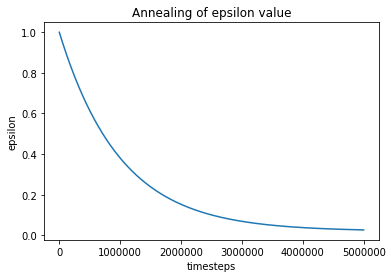

In [31]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def update_epsilon(time_step, min_epsilon, max_epsilon, epsilon_decay):

    epsilon = min_epsilon + \
                   (max_epsilon - min_epsilon) \
                   * math.exp(-epsilon_decay * time_step)
    return epsilon

# These values will nicely decrease epsilon value to 0.02 within a million timesteps.
# For games harder even smaller epsilon decay values are used.
start_epsilon = 1.0
end_epsilon = 0.02
epsilon_decay = 1e-6

total_timesteps = 5e6

timesteps = np.linspace(0, 5e6, 1000)
epsilon_values = [update_epsilon(t, end_epsilon, start_epsilon, epsilon_decay) for t in timesteps]
ax = sns.lineplot(timesteps, epsilon_values)
ax.set(xlabel='timesteps', ylabel='epsilon')
plt.title('Annealing of epsilon value')
plt.show()

## Training

In [4]:
import gym
from env_wrappers import AtariFrameStack
from dqn import DeepQNetwork, EpsilonGreedyAgent
from os.path import join

EXPERIMENT_FOLDER = 'Experiments/pong_dqn_01'
video_folder = join(EXPERIMENT_FOLDER, 'video')
save_interval = 100

env = AtariFrameStack(gym.make('PongNoFrameskip-v4'),
                      frame_skip=4,
                      terminal_on_life_loss=False,
                      screen_size=84,
                      stack_size=4,
                      skip_init=1)
from gym.wrappers import monitor
env = gym.wrappers.Monitor(env, video_folder, force=True,
                          video_callable=lambda episode_id: episode_id % save_interval == 0)
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(state_shape=env.observation_space.shape,
                         n_actions=env.action_space.n,
                         learning_rate=6.25e-5,
                         gamma=0.99)

agent = EpsilonGreedyAgent(n_actions=env.action_space.n,
                   network=q_network,
                   replay_capacity=50000,
                   gamma=0.99,  # discount of future rewards
                   training_start=10000,  # start training after x number of steps
                   training_interval=4,  # train every x steps
                   batch_size=32,
                   start_epsilon=1.0,
                   end_epsilon=0.02,
                   epsilon_decay=1e-6,
                   root_folder=EXPERIMENT_FOLDER,
                   save_best=True,
                   save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(84, 84, 4)
Action space: Discrete(6)


In [ ]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from dqn import run_experiment

run_experiment(env, agent, runs=2500, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ])
env.close()

In [8]:
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))

# Save history file
from dqn import save_history
save_history(history, join(EXPERIMENT_FOLDER, 'history.json'))

INFO:tensorflow:Assets written to: pong_dqn/latest/assets


## Pre-trained agent
### Checking history
Since training can take up to 8 hours on average GPUs, we have pre-trained a Pong agents that you can load and experiment with. You can check the history of the training process by loading up the history with the following code.

dict_keys(['score', 'steps_per_game', 'framerate', 'runs', 'return', 'epsilon', 'loss', 'steps'])


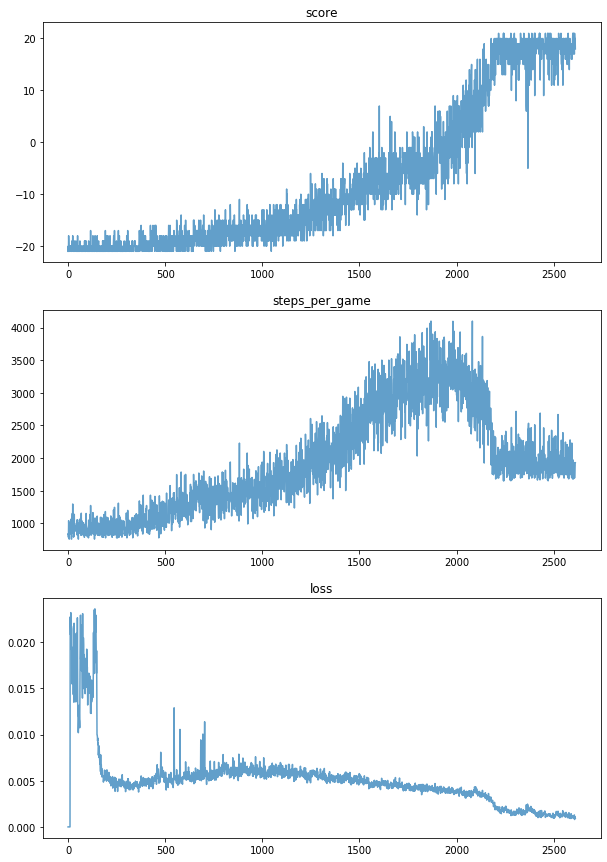

In [2]:
from dqn import load_history, plot_history
from os.path import join

EXPERIMENT_FOLDER = 'Experiments/pong_dqn'
history = load_history(join(EXPERIMENT_FOLDER, 'history.json'))
print(history.keys())
plot_history(history, ['score', 'steps_per_game', 'loss'])

### To load the agent and play the game

- Set the experiment folder to the ```EXPERIMENT_FOLDER``` variable
- Create the environment
- Create a instance of a network.
- Load the weights with ```q_network.load(path)```
- Create an agent ```EpsilonGreedyAgent(network=q_network)```
- Remember to set ``````EpsilonGreedyAgent(start_epsilon=0.02)`````` to a small value, to ensure exploration.

In [3]:
from os.path import join

import gym

from dqn import EpsilonGreedyAgent, DeepQNetwork
from env_wrappers import AtariFrameStack

EXPERIMENT_FOLDER = 'Experiments/pong_dqn'

env = AtariFrameStack(gym.make('PongNoFrameskip-v4'))
q_network = DeepQNetwork(state_shape=env.observation_space.shape,
                         n_actions=env.action_space.n)
# Load the network
q_network.load(join(EXPERIMENT_FOLDER, 'latest'))

agent = EpsilonGreedyAgent(n_actions=env.action_space.n, network=q_network, start_epsilon=0.02)

### Let the agent play and record the video

In [4]:
from dqn import run_episode

video_path = join(EXPERIMENT_FOLDER, 'videos')
                  
env = gym.wrappers.Monitor(env, video_path, force=True)
print(run_episode(env, agent, train=False))
env.close()

{'score': 19.0, 'steps_per_game': 1857, 'framerate': 263.61016122653547, 'runs': 0, 'return': 0, 'epsilon': 0.02, 'loss': 0, 'steps': 0}


In [5]:
from IPython.display import Video
import os

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name))

### Training progress
Here is couple of videos that were captured during the training process.

#### 1000 episodes, Reward: -12

In [6]:
from IPython.display import Video
Video("GIF/dqn_pong_-12.mp4")

### 2000 episodes, Reward: -3

In [22]:
from IPython.display import Video
Video("GIF/pong_dqn_-3.mp4")

### 2500 episodes, Reward: 18

In [8]:
Video("GIF/dqn_pong_18.mp4")

# Assigment

If you've solved Pong you're ready to go to the next game: Breakout. Train your own DQN to play Breakout.

# References

[1] Richard Sutton & Andrew Barto, Reinforcement Learning – An Introduction, november 2018
